In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup

plt.rcParams['font.family'] = "Meiryo"

In [2]:
# football-labの試合URLを入力する
inURL='https://www.football-lab.jp/nago/report?year=2024&month=04&date=07'

# スクレイピング対象の URL にリクエストを送り HTML を取得する
res = requests.get(inURL)

# レスポンスの HTML から BeautifulSoup オブジェクトを作る
soup = BeautifulSoup(res.text, 'html.parser')

# ホームチーム名
elems=soup.select('body > article > div.vsHeader > table > tr:nth-child(3) > td.tName.r > span > a')
homeTeamName=(elems[0].contents[0])
print('ホームチーム：'+homeTeamName)

# アウェーチーム名
elems=soup.select('body > article > div.vsHeader > table > tr:nth-child(3) > td.tName.l > span > a')
awayTeamName=(elems[0].contents[0])
print('アウェーチーム：'+awayTeamName)

# ホームチーム得点
elems=soup.select('body > article > div.vsHeader > table >  tr:nth-child(3) > td:nth-child(2)')
homeGoals=int(elems[0].contents[0])

# アウェーチーム得点
elems=soup.select('body > article > div.vsHeader > table >  tr:nth-child(3) > td:nth-child(4)')
awayGoals=int(elems[0].contents[0])
print('得点：'+str(homeGoals)+'-'+ str(awayGoals))

# ゴール期待値
elems=soup.find_all(text=re.compile('ゴール期待値'))
elems2=elems[1].next_element.next_element.next_element
xg_away=float(elems2)
elems3=elems[1].previous_element.previous_element.previous_element
xg_home=float(elems3)
print('ゴール期待値：'+str(xg_home) +'-'+ str(xg_away))

elems=soup.select('body > article > div:nth-child(10) > table:nth-child(45) > tbody > tr:nth-child(4) > td:nth-child(4)')
elems2=elems[0].next_element.next_element.next_element.next_element
numShots_away=int(elems2)

elems2=elems[0].previous_element.previous_element
numShots_home=int(elems2)
print('シュート数：'+str(numShots_home) +'-'+ str(numShots_away))


ホームチーム：名古屋グランパス
アウェーチーム：アビスパ福岡
得点：0-0
ゴール期待値：0.131-1.061
シュート数：4-14


Text(0, 0.5, 'HOME 名古屋グランパス')

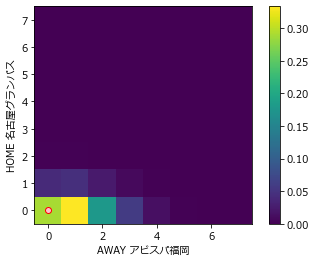

In [3]:

numGoal_UL=15 # 計算するゴール数の上限
numGoal_plot_UL=max([8, homeGoals+1, awayGoals+1]) # 表示するゴール数の上限

mu_xG_home = xg_home/numShots_home
mu_xG_away = xg_away/numShots_away

p=np.array([1-mu_xG_home, mu_xG_home])
tmp=1
for n1 in range(numShots_home):
    tmp=np.convolve(tmp,p)

p_home=tmp

p=np.array([1-mu_xG_away, mu_xG_away])
tmp=1
for n1 in range(numShots_away):
    tmp=np.convolve(tmp,p)

p_away=tmp

p_mat=np.zeros((np.max( [numShots_home,numGoal_UL]), \
                np.max([numShots_away,numGoal_UL])))

for n1 in range(numShots_home):
    for n2 in range(numShots_away):
        p_mat[n1,n2]=p_home[n1]*p_away[n2]


plt.imshow(p_mat[(numGoal_plot_UL-1)::-1,0:numGoal_plot_UL],\
           extent=(-0.5,numGoal_plot_UL-0.5,-0.5,numGoal_plot_UL-0.5))
plt.colorbar()
plt.scatter(awayGoals,homeGoals,c="pink",edgecolors="red")
plt.xlabel('AWAY'+' '+ awayTeamName)
plt.ylabel('HOME'+' '+homeTeamName)

Win  prob.= 0.044
Draw prob.= 0.337
Lose prob.= 0.619
True
AxesSubplot(0.125,0.125;0.775x0.755)


Text(0.5, 1.0, '名古屋グランパス(H) 0-0 アビスパ福岡(A)')

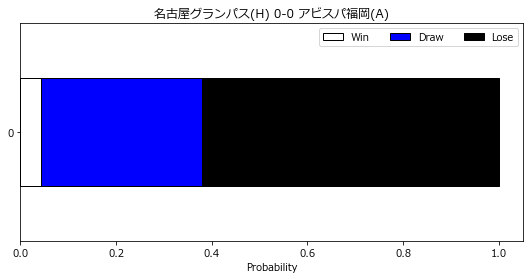

In [9]:
p_win=(np.sum( np.tril(p_mat,k=-1), axis=None))

p_draw=(np.sum(np.diag(p_mat)))

p_lose=np.sum(np.triu(p_mat,k=1), axis=None)

print('Win  prob.= '+'{:1.3f}'.format(p_win))
print('Draw prob.= '+'{:1.3f}'.format(p_draw))
print('Lose prob.= '+'{:1.3f}'.format(p_lose))

df = pd.DataFrame({
    'Win':p_win,
    'Draw':p_draw,
    'Lose':p_lose
}, index=[0])

print(homeGoals==awayGoals)
if homeGoals>awayGoals:
    ax=df.plot(kind='barh', stacked=True,figsize=(9, 4),color={"Win":"blue", "Draw":"gray","Lose":"Black"})
elif homeGoals==awayGoals:
    ax=df.plot(kind='barh', stacked=True,figsize=(9, 4),color={"Win":"white", "Draw":"blue","Lose":"Black"} \
              ,edgecolor="Black")    
else:
    ax=df.plot(kind='barh', stacked=True,figsize=(9, 4),color={"Win":"white", "Draw":"gray","Lose":"Blue"} \
              ,edgecolor="Black")    
    
print(ax)

ax.set_xlabel('Probability')
ax.legend(ncol=3)
ax.set_title(homeTeamName +'(H) ' +str(homeGoals) +'-'+ str(awayGoals)+ ' ' + awayTeamName+'(A)')